# Extracting low water line boundaries for Queensland Ramsar sites <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 


## Description
Project in collaboration with Queensland Department of Environment and Science
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [11]:
import sys
import datacube
import numpy as np
import xarray as xr
import geopandas as gpd
# from shapely.geometry import MultiLineString
from datacube.utils import geometry
from skimage.morphology import remove_small_holes
from skimage.filters import gaussian

sys.path.append('../Scripts')
from dea_plotting import map_shapefile
from dea_spatialtools import subpixel_contours  #, largest_region


def split_longest(geom):
    """
    Takes a MultiLineString, and returns only the longest LineString
    in that feature.
    """

    # Break MultiLineString into individual lines
    geoms = geom.explode().reset_index(drop=True)
    
    # Identify longest line
    is_longest = geoms.length == max(geoms.length)
    longest_geom = geoms[is_longest].iloc[0]
    
    # Create MultiLineString if required, otherwise return LineString
    try:     
        other_geoms = geoms[~is_longest].unary_union
    except:
        other_geoms = geoms[~is_longest]
    
    return [longest_geom, other_geoms]

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='DES_Ramsar_boundaries')

### Analysis parameters

* `boundary_shp`: Path to the shapefile containing boundaries for the Ramsar site


In [3]:
boundary_shp = 'Bounding Area.shp'
# boundary_shp = 'extent_small.geojson'

## Load data
### Load extent

In [4]:
boundary_gdf = gpd.read_file(boundary_shp).to_crs('EPSG:3577')
geom = geometry.Geometry(geom=boundary_gdf.iloc[0].geometry, 
                         crs=boundary_gdf.crs)

map_shapefile(boundary_gdf, attribute='Id')

Label(value='')

Map(center=[-19.304967557049636, 147.2000000000006], controls=(ZoomControl(options=['position', 'zoom_in_text'…

### Load intertidal data

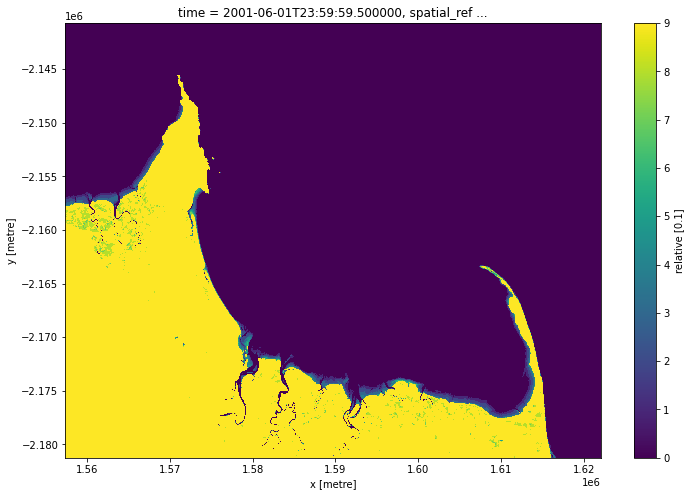

In [5]:
# Load data
item = dc.load(product='item_v2',
               geopolygon=geom).relative.squeeze(dim='time')
nidem = dc.load(product='nidem',
                geopolygon=geom).nidem.squeeze(dim='time')

# Set nodata to NaN
item = item.where(item != -6666)
nidem = nidem.where(nidem != -9999)

# Plot
item.plot(size=8)

## Extract coastline

In [17]:
# Extract each line feature
for interval in [1, 2, 3, 4]:
    
    # Convert to two classes around specified interval
    item_thresh = item >= interval
    
    # Remove inland lakes
    item_nolakes = xr.apply_ufunc(remove_small_holes, item_thresh, 1000, 1)

    # Clean edges by applying a gaussian filter to produce smooth lines 
    # in the output shapefile
    item_smoothed = xr.apply_ufunc(gaussian, item_nolakes)

    # Extract contour along 0.0 and 1.0 boundary (i.e. 0.5)
    item_contour = subpixel_contours(item_smoothed, 0.5, 
                                     crs='EPSG:3577', 
                                     find_contours_kwargs={'fully_connected': 'low'})
    item_contour = item_contour.drop('z_value', axis=1)
    
    # Extract typical elevation from NIDEM and add as attribute to shapefile
    x_coords, y_coords = np.concatenate(
        [i.coords.xy for i in item_contour['geometry'][0]], axis=1)
    x, y = xr.DataArray(x_coords, dims='z'), xr.DataArray(y_coords, dims='z')
    elev_m = nidem.interp(x=x, y=y).mean().round(2).values

    # Remove any small disconnected lines in the data
    item_coastline = gpd.GeoDataFrame(
        data={'type': ['contiguous', 'non-contiguous']}, 
        geometry=split_longest(geom=item_contour['geometry']))

    # Unclipped data to file
    suffix = (interval - 1) * 10
    item_coastline['tide_perc'] = suffix
    item_coastline['elev_m'] = elev_m
    item_coastline = item_coastline.explode().reset_index(drop=True)
    item_coastline.crs = item.geobox.crs
    item_coastline.to_crs('EPSG:4326').to_file(
        f'coastline_all/coastline_all_{suffix}_percentile_obs_tide.geojson', driver='GeoJSON')
    item_coastline.to_file(f'coastline_all/coastline_all_{suffix}_percentile_obs_tide.shp')
    
    # Clip to extent and export to file
    item_coastline_clipped = gpd.clip(item_coastline, boundary_gdf)
    item_coastline_clipped.to_crs('EPSG:4326').to_file(
        f'coastline_clipped/coastline_clipped_{suffix}_percentile_obs_tide.geojson', driver='GeoJSON')
    item_coastline_clipped.to_file(f'coastline_clipped/coastline_clipped_{suffix}_percentile_obs_tide.shp')
    
    

Operating in multiple z-value, single array mode
Operating in multiple z-value, single array mode
Operating in multiple z-value, single array mode
Operating in multiple z-value, single array mode


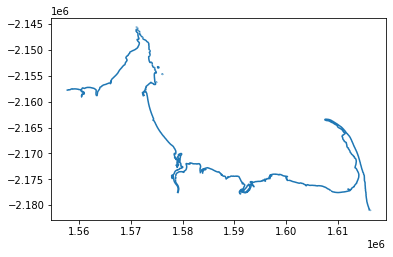

## Zip

In [18]:
import shutil
shutil.make_archive('coastline_all', 'zip', 'coastline_all')
shutil.make_archive('coastline_clipped', 'zip', 'coastline_clipped')

'/home/jovyan/dev/dea-notebooks/DES_Ramsar/coastline_clipped.zip'

## Other

In [ ]:

def xr_sample(da, 
              geo, 
              method='nearest',
              reduce_func='mean'):    
    
    output_stats = []

    for g in geo:    

        # Extract coordinates used to sample array
        x_coords, y_coords = g.coords.xy
        x, y = xr.DataArray(x_coords, dims='z'), xr.DataArray(y_coords, dims='z')

        # Sample array
        da_interp = da.interp(x=x, y=y, method=method)

        # Compute stats
        reduce_method = getattr(da_interp, reduce_func)
        da_agg = reduce_method().item()

        # Add to list
        output_stats.append(da_agg)
    
    return output_stats
    
    
xr_sample(da=nidem, 
          geo=geo, 
          reduce_func='median',
          method='nearest')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)